In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from rpy2.robjects.packages import importr
from rpy2.robjects import r
from rpy2.robjects import pandas2ri

pandas2ri.activate()

%matplotlib inline

In [2]:
charlotte_rainfall = pd.read_csv('./charlotte_2_rg_2011.csv', header = None)
charlotte_rainfall.columns = ["year","month","day", "hour", "min", "Rainfall_1", "Rainfall_2"]
charlotte_rainfall.loc[:,'dt'] = pd.to_datetime(dict(year=charlotte_rainfall['year'], month=charlotte_rainfall['month'], day=charlotte_rainfall['day'], hour=charlotte_rainfall['hour'], minute=charlotte_rainfall['min']))
charlotte_rainfall.index=charlotte_rainfall['dt']
charlotte_rainfall.drop('year', 1, inplace=True)
charlotte_rainfall.drop('month', 1, inplace=True)
charlotte_rainfall.drop('day', 1, inplace=True)
charlotte_rainfall.drop('hour', 1, inplace=True)
charlotte_rainfall.drop('min', 1, inplace=True)
charlotte_rainfall.drop('dt', 1, inplace=True)

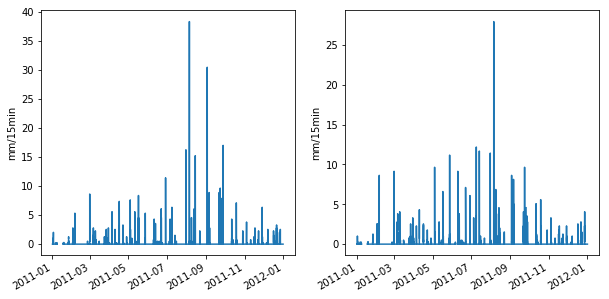

In [3]:
charlotte_rainfall["Rainfall_1"] = charlotte_rainfall["Rainfall_1"].replace(-99, np.nan)
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(charlotte_rainfall.index, charlotte_rainfall["Rainfall_1"])
plt.ylabel('mm/15min')
fig.autofmt_xdate()

charlotte_rainfall["Rainfall_2"] = charlotte_rainfall["Rainfall_2"].replace(-99, np.nan)
plt.subplot(122)
plt.plot(charlotte_rainfall.index, charlotte_rainfall["Rainfall_2"])
plt.ylabel('mm/15min')
fig.autofmt_xdate()

#### Accumulate 24h

In [5]:
charlotte_24h_rainfall = pd.DataFrame()
charlotte_24h_rainfall['mean_rain_1'] = charlotte_rainfall.Rainfall_1.resample('D').mean()
charlotte_24h_rainfall['accum_rain_1'] = charlotte_rainfall.Rainfall_1.resample('D').sum()
charlotte_24h_rainfall['mean_rain_2'] = charlotte_rainfall.Rainfall_2.resample('D').mean()
charlotte_24h_rainfall['accum_rain_2'] = charlotte_rainfall.Rainfall_2.resample('D').sum()

#### Select only dates with rainfall

In [8]:
mask = (charlotte_24h_rainfall.accum_rain_1 == 0) | (charlotte_24h_rainfall.accum_rain_2 == 0)
charlotte_24h_rainfall = charlotte_24h_rainfall.loc[~mask]
mask = (np.isnan(charlotte_24h_rainfall.accum_rain_1)) | (np.isnan(charlotte_24h_rainfall.accum_rain_2))
charlotte_24h_rainfall = charlotte_24h_rainfall.loc[~mask]

# Do the same with 15 min data
mask = (charlotte_rainfall.Rainfall_1 == 0) | (charlotte_rainfall.Rainfall_2 == 0)
charlotte_rainfall = charlotte_rainfall.loc[~mask]
mask = (np.isnan(charlotte_rainfall.Rainfall_1)) | (np.isnan(charlotte_rainfall.Rainfall_2))
charlotte_rainfall = charlotte_rainfall.loc[~mask]

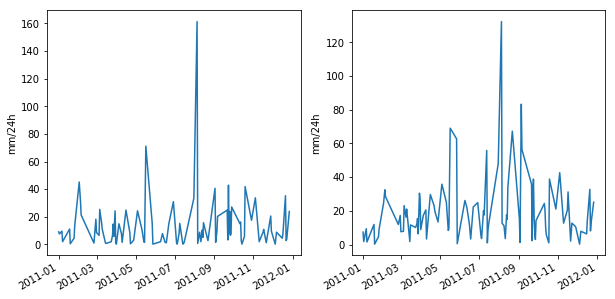

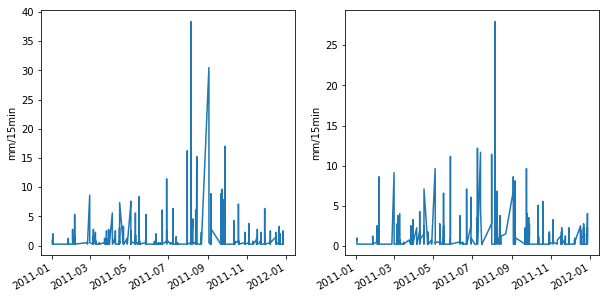

In [10]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(charlotte_24h_rainfall.index, charlotte_24h_rainfall['accum_rain_1'])
plt.ylabel('mm/24h')
fig.autofmt_xdate()

plt.subplot(122)
plt.plot(charlotte_24h_rainfall.index, charlotte_24h_rainfall['accum_rain_2'])
plt.ylabel('mm/24h')
fig.autofmt_xdate()

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(charlotte_rainfall.index, charlotte_rainfall['Rainfall_1'])
plt.ylabel('mm/15min')
fig.autofmt_xdate()

plt.subplot(122)
plt.plot(charlotte_rainfall.index, charlotte_rainfall['Rainfall_2'])
plt.ylabel('mm/15min')
fig.autofmt_xdate()

#### Use seconds as x and zeros as y

In [12]:
charlotte_24h_rainfall['seconds'] = charlotte_24h_rainfall.index.astype(np.int64) // 10 ** 9 - ( charlotte_24h_rainfall.index.astype(np.int64)[0] // 10 ** 9)
charlotte_24h_rainfall['zeros'] = np.zeros((len(charlotte_24h_rainfall.accum_rain_1), 1), dtype=np.int8)

charlotte_rainfall['seconds'] = charlotte_rainfall.index.astype(np.int64) // 10 ** 9 - ( charlotte_rainfall.index.astype(np.int64)[0] // 10 ** 9)
charlotte_rainfall['zeros'] = np.zeros((len(charlotte_rainfall.Rainfall_1), 1), dtype=np.int8)

In [13]:
sp = importr('sp')
gstat = importr('gstat')
intamap = importr('intamap')

r('jet.colors  <- c("#00007F","blue","#007FFF","cyan","#7FFF7F","yellow","#FF7F00","red","#7F0000")')
r('col.palette <- colorRampPalette(jet.colors)')

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7fd4d0fbc688 / R:0x5560fe8ec438>

### Respect the time (in seconds)

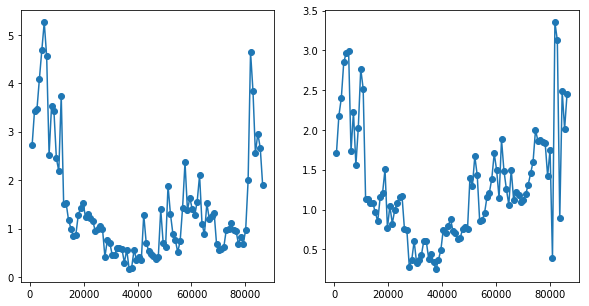

In [15]:
#charlotte_rainfall['seconds'] = charlotte_24h_rainfall.index.astype(np.int64) // 10 ** 9 - ( charlotte_24h_rainfall.index.astype(np.int64)[0] // 10 ** 9)
rain1 = charlotte_rainfall[['Rainfall_1', 'seconds', 'zeros']]
rain2 = charlotte_rainfall[['Rainfall_2', 'seconds', 'zeros']]

r_df = pandas2ri.py2ri(rain1)
r.assign('mydata', r_df)
r_df2 = pandas2ri.py2ri(rain2)
r.assign('mydata2', r_df2)

r('''
mydata <- data.frame(mydata)
coordinates(mydata) <- ~seconds+zeros

mydata2 <- data.frame(mydata2)
coordinates(mydata2) <- ~seconds+zeros
''')

p_myiso = r('myiso <- variogram(Rainfall_1~1,mydata,width=900,cutoff=86400)')
p_myiso2 = r('myiso2 <- variogram(Rainfall_2~1,mydata2,width=900,cutoff=86400)')

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(p_myiso['dist'], p_myiso['gamma'], '-o')
plt.subplot(122)
plt.plot(p_myiso2['dist'], p_myiso2['gamma'], '-o')

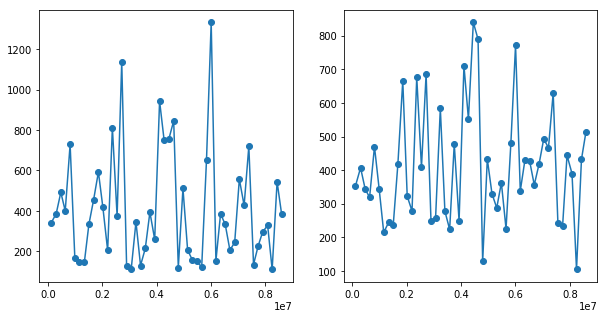

In [29]:
charlotte_24h_rainfall['seconds'] = charlotte_24h_rainfall.index.astype(np.int64) // 10 ** 9 - ( charlotte_24h_rainfall.index.astype(np.int64)[0] // 10 ** 9)
rain1 = charlotte_24h_rainfall[['accum_rain_1', 'seconds', 'zeros']]
rain2 = charlotte_24h_rainfall[['accum_rain_2', 'seconds', 'zeros']]

r_df = pandas2ri.py2ri(rain1)
r.assign('mydata', r_df)
r_df2 = pandas2ri.py2ri(rain2)
r.assign('mydata2', r_df2)

r('''
mydata <- data.frame(mydata)
coordinates(mydata) <- ~seconds+zeros

mydata2 <- data.frame(mydata2)
coordinates(mydata2) <- ~seconds+zeros
''')

p_myiso = r('myiso <- variogram(accum_rain_1~1,mydata,width=172800,cutoff=8640000)')
p_myiso2 = r('myiso2 <- variogram(accum_rain_2~1,mydata2,width=172800,cutoff=8640000)')

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(p_myiso['dist'], p_myiso['gamma'], '-o')
plt.subplot(122)
plt.plot(p_myiso2['dist'], p_myiso2['gamma'], '-o')

### Ignore the observation time and just ascend it...

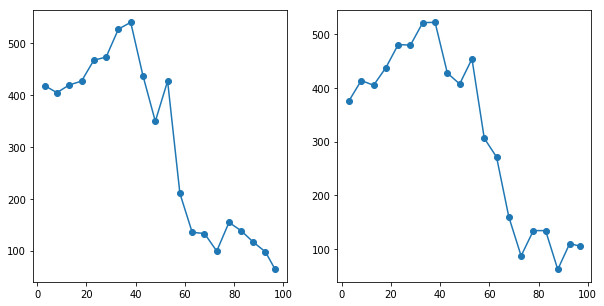

In [30]:
charlotte_24h_rainfall['seconds'] = np.arange(0,len(charlotte_24h_rainfall.accum_rain_1), 1)

rain1 = charlotte_24h_rainfall[['accum_rain_1', 'seconds', 'zeros']]
rain2 = charlotte_24h_rainfall[['accum_rain_2', 'seconds', 'zeros']]

r_df = pandas2ri.py2ri(rain1)
r.assign('mydata', r_df)
r_df2 = pandas2ri.py2ri(rain2)
r.assign('mydata2', r_df2)

r('''
mydata <- data.frame(mydata)
coordinates(mydata) <- ~seconds+zeros

mydata2 <- data.frame(mydata2)
coordinates(mydata2) <- ~seconds+zeros
''')

p_myiso = r('myiso <- variogram(accum_rain_1~1,mydata,width=5,cutoff=200)')
p_myiso2 = r('myiso2 <- variogram(accum_rain_2~1,mydata2,width=5,cutoff=200)')

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(p_myiso['dist'], p_myiso['gamma'], '-o')
plt.subplot(122)
plt.plot(p_myiso2['dist'], p_myiso2['gamma'], '-o')

## Select rainfall on 5th August (15 min sampling)

In [32]:
event_rain = charlotte_rainfall.loc['2011-08-05 00:00:00':'2011-08-05 23:59:59']
event_rain_1 = event_rain.Rainfall_1
event_rain_2 = event_rain.Rainfall_2

In [35]:
event_rain_2.index = event_rain_2.index + dt.timedelta(hours=72)
my_event = event_rain_1.append(event_rain_2)
my_event = pd.DataFrame(my_event)
my_event.columns = ['R']
my_event['zeros'] = np.zeros((len(my_event.R), 1), dtype=np.int8)

## Taking time into account (but the time gap of 72h won't be seen with the current cutoff)

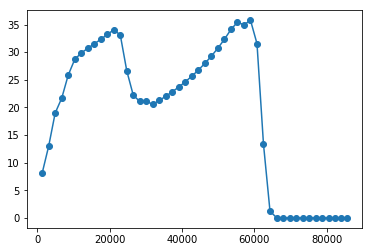

In [39]:
my_event['seconds'] = my_event.index.astype(np.int64) // 10 ** 9 - ( my_event.index.astype(np.int64)[0] // 10 ** 9)
r_df = pandas2ri.py2ri(my_event)
r.assign('mydata_event', r_df)

r('''
mydata_event <- data.frame(mydata_event)
coordinates(mydata_event) <- ~seconds+zeros
''')

p_myiso = r('myiso_event <- variogram(R~1,mydata_event,width=1800,cutoff=90000)')
plt.plot(p_myiso['dist'], p_myiso['gamma'], '-o')

#### Ignore time

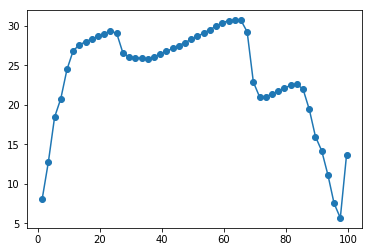

In [44]:
my_event['seconds'] = np.arange(0,len(my_event.R), 1)
r_df = pandas2ri.py2ri(my_event)
r.assign('mydata_event', r_df)

r('''
mydata_event <- data.frame(mydata_event)
coordinates(mydata_event) <- ~seconds+zeros
''')

p_myiso = r('myiso_event <- variogram(R~1,mydata_event,width=2,cutoff=100)')
plt.plot(p_myiso['dist'], p_myiso['gamma'], '-o')

In [45]:
from pandas.plotting import autocorrelation_plot

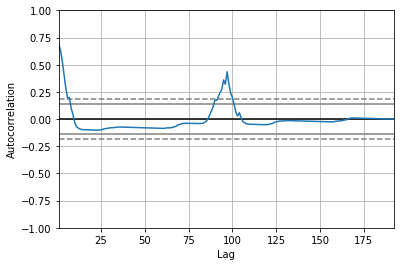

In [47]:
autocorrelation_plot(my_event.R)

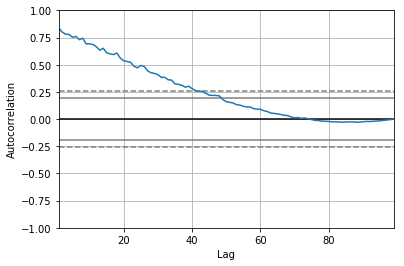

In [48]:
autocorrelation_plot(rain1)

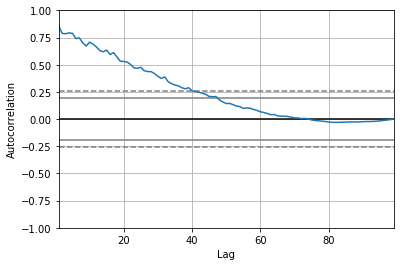

In [49]:
autocorrelation_plot(rain2)